## DEMAND FORECASTING

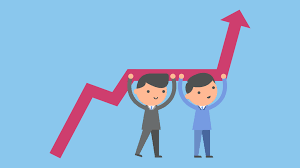

<b>Demand Forecasting is the process in which historical sales data is used to develop an estimate of an expected forecast of customer demand. To businesses, Demand Forecasting provides an estimate of the amount of goods and services that its customers will purchase in the foreseeable future.</i>

# 1.0 Import Library

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import os
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import lightgbm as lgb
plt.style.use('ggplot')
seed = 433

## 1.2 Load the datasets

In [2]:
os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")
# First let us load the datasets into different Dataframes
train_df = pd.read_csv('train.csv')

# Dimensions
print('Train shape:', train_df.shape)
# Set of features we have are: date, store, and item
display(train_df.sample(10))

Train shape: (913000, 4)


,date,store,item,sales
570981,2016-06-23,3,32,65
546305,2013-11-28,10,30,37
69767,2014-01-15,9,4,15
167389,2016-05-08,2,10,154
109374,2017-06-29,10,6,103
561901,2016-08-12,8,31,98
153766,2014-01-18,5,9,23
897172,2014-08-30,2,50,88
169451,2016-12-30,3,10,65
746260,2016-06-06,9,41,24


## Distribution of sales
Now let us understand how the sales varies across all the items in all the stores

In [3]:
# Sales distribution across the train data
sales_df = train_df.copy(deep=True)
sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
print('Max sale:', sales_df.sales.max())
print('Min sale:', sales_df.sales.min())
print('Avg sale:', sales_df.sales.mean())
print()

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

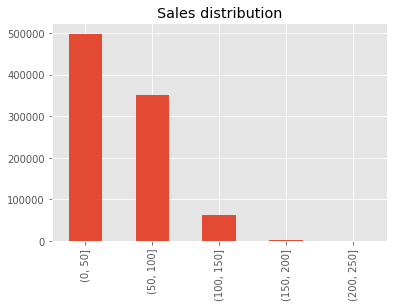

In [4]:
# Let us visualize the same
pd.value_counts(sales_df.sales_bins).plot(kind='bar', title='Sales distribution');

As we can see, almost 92% of sales are less than 100. Max, min and average sales are 231, 0 and 52.25 respectively.   
So any prediction model has to deal with the skewness in the data appropriately. 

## How does sales vary across stores
Let us get a overview of sales distribution in the whole data.

In [5]:
# Let us understand the sales data distribution across the stores
store_df = train_df.copy()
sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
# Pivoted dataframe
display(sales_pivoted_df)

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                   ...                        \
item          7          8          9          10  ...         41         42   
store                                              ...                         
1      52.783680  69.472070  46.504929  66.354326  ...  20.002738  33.105696   
2      75.058598  99.090361  65.478094  94.097481  ...  28.069551  47.368018   
3      66.647864  87.517525  58.486857  83.387733  ...  24.989047  41.797371   
4      61.625411  80.819825  54.043812  77.047645  ...  23.168127  38.539978   
5      44.535597  58.565717  38.837349  55.509858  ...  16.830778  27.730559   
6      44.599124  58.385542  39.460022  55.565170  ...  16.607338  27.893209   
7      40.709748  53.723987  35.901972  51.156627  ...  15.471522  25.435926   
8      71.730559  94.461117  63.193319  89.818182  ...  27.036145  45.144031   
9      61.812158  81.287514  54.105696  77.105148  ...  23.191128  38.643483   
10     65.807777  86.176889  57.886637  82.232202  ...  24.654984  41.222892   

                                                                          \
item          43         44          45         46         47         48   
store                                                                      
1      46.242607  26.594195   72.720701  52.845016  19.814348  46.546002   
2      65.785323  37.785871  103.381161  75.219606  28.187842  66.028478   
3      58.197700  33.386090   91.851041  66.748083  25.120482  58.700986   
4      54.018620  30.952355   84.687295  61.420044  23.114458  53.765608   
5      39.163198  22.415115   61.427163  44.734940  16.699343  39.281490   
6      39.034502  22.322563   61.142935  44.539978  16.708653  39.052574   
7      35.426068  20.446331   55.905805  40.828587  15.479189  35.624315   
8      62.980285  36.194414   98.941402  72.004929  27.150055  62.737130   
9      54.152793  30.968237   85.093647  62.010953  23.003286  53.976999   
10     57.942497  32.916758   90.690581  66.046550  24.755750  57.814896   

                             
item          49         50  
store                        
1      26.461665  59.342826  
2      37.711939  84.622125  
3      33.259584  74.958379  
4      30.840635  68.921687  
5      22.371851  50.319277  
6      22.181271  50.516429  
7      20.406353  45.823658  
8      36.035049  80.972070  
9      31.052574  69.308324  
10     33.032311  74.037240  

[10 rows x 50 columns]

This pivoted dataframe has average sales per each store per each item.  
Let use this dataframe and produce some interesting visualizations!

In [6]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [7]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

From the visualization, it is clear that the stores with ID 2 and 8 have higher average sales than the remaining stores and is a clear indication that they are doing good money!

Whereas store with ID 7 has very poor performance in terms of average sales.

## How does sales vary across items

In [8]:
# Let us calculate the average sales of each of the item across all the stores
sales_across_item_df = sales_pivoted_df.copy()
# Aggregate the sales per item and add it as a new row in the same dataframe
sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
# Note the 11th index row, which is the average sale of each of the item across all the stores
#display(sales_across_item_df.loc[11:])
avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
# And finally, sort by avg sale
avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
# Display the top 10 rows
display(avg_sales_per_item_across_stores_df.head())

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


Great! Let us visualize these average sales per item!

In [9]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

Amazing! The sales is uniformly distributed across all the items.   
Top items with highest average sale are 15, 28, 13, 18 and with least average sales are 5, 1, 41 and so on.

## Time-series visualization of the sales
Let us see how sales of a given item in a given store varies in a span of 5 years.

In [10]:
store_item_df = train_df.copy()
# First, let us filterout the required data
store_id = 10   # Some store
item_id = 40    # Some item
print('Before filter:', store_item_df.shape)
store_item_df = store_item_df[store_item_df.store == store_id]
store_item_df = store_item_df[store_item_df.item == item_id]
print('After filter:', store_item_df.shape)
#display(store_item_df.head())

# Let us plot this now
store_item_ts_data = [go.Scatter(
    x=store_item_df.date,
    y=store_item_df.sales)]
py.iplot(store_item_ts_data)

Before filter: (913000, 4)
After filter: (1826, 4)


Woww! Clearly there is a pattern here! Feel free to play around with different store and item IDs.   
Almost all the items and store combination has this pattern!

The sales go high in June, July and August months. The sales will be lowest in December, January and February months. That's something!!

Let us make it more interesting. What if we aggregate the sales on a montly basis and compare different items and stores.   
This should help us understand how different item sales behave at a high level.

In [11]:
multi_store_item_df = train_df.copy()
# First, let us filterout the required data
store_ids = [1, 1, 1, 1]   # Some stores
item_ids = [10, 20, 30, 40]    # Some items
print('Before filter:', multi_store_item_df.shape)
multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
print('After filter:', multi_store_item_df.shape)
#display(multi_store_item_df)
# TODO Monthly avg sales

# Let us plot this now
multi_store_item_ts_data = []
for st,it in zip(store_ids, item_ids):
    flt = multi_store_item_df[multi_store_item_df.store == st]
    flt = flt[flt.item == it]
    multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
py.iplot(multi_store_item_ts_data)

Before filter: (913000, 4)
After filter: (7304, 4)


Interesting!!   
Though the pattern remains same across different stores and items combinations, the **actual sale value consitently varies with the same scale**. 

As we can see in the visualization, item 10 has consistently highest sales through out the span of 5 years!   
This is an interesting behaviour that can be seen across almost all the items. 



In [12]:
import os
os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")
train = pd.read_csv('train.csv',parse_dates=[0],nrows=None)
test = pd.read_csv('test.csv',parse_dates=[1], nrows=None )
print('Number of rows and columns in train dataset are:',train.shape)
print('Number of rows and columns in test dataset are:', test.shape)

Number of rows and columns in train dataset are: (913000, 4)
Number of rows and columns in test dataset are: (45000, 4)


### 1.3 Useful function

In [13]:
def basic_details(df):
    """Find number of missing value,dtyeps, unique value in 
    dataset"""
    k = pd.DataFrame()
    k['Missing value'] = df.isnull().sum()
    k['% Missing value'] = df.isnull().sum()/df.shape[0]
    k['dtype'] = df.dtypes
    k['N unique'] = df.nunique()
    return k

In [14]:
def agg_stats(df,statistics,groupby_column):
    """Aggregate a column by unit sales statistics such as 
    'mean','sum','min','max', 'var', 'std',"""
    f,ax = plt.subplots(3,2,figsize=(14,8))
    ax =ax.ravel()
    for i,s in enumerate(statistics):
        tmp = (df
         .groupby(groupby_column)
         .agg({'sales':s})
         )
        tmp.columns = ['sales_{}'.format(s)]
        sns.lineplot(x=tmp.index, y = tmp.iloc[:,0],color='blue',ax=ax[i])
        ax[i].set_xticks(tmp.index)
        for ticks in ax[i].get_xticklabels(): ticks.set_rotation(90)
        #plt.xticks(rotation=90)
        ax[i].set_title('sales_{}'.format(s))
        ax[i].set_ylabel('')
    plt.tight_layout()

In [15]:
### date_time_feat
def date_time_feat(df,column):
    "Extract date time feature"
    df['day'] = df[column].dt.day
    df['dayofweek'] = df[column].dt.dayofweek
    df['month'] = df[column].dt.month
    df['year'] = df[column].dt.year
    
    df['is_month_end'] = df[column].dt.is_month_end.astype('int8')
    df['is_month_start'] = df[column].dt.is_month_start.astype('int8')
    df['weekofyear'] = df[column].dt.weekofyear
    # conver to category
    #df['dayofweek'] = pd.Categorical(df['dayofweek'],
     #       categories=['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday',])


In [16]:
# Reduce memory of dataset
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe """
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')

## 2.0 Exploratory data analysis
Glimpse dataset

In [17]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [18]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


The test dataset contains id column but train dataset does not contains id column. While importing dataset parse_date is assigned with perticular column index.

In [19]:
basic_details(test) # test dataset

,Missing value,% Missing value,dtype,N unique
id,0,0.0,int64,45000
date,0,0.0,datetime64[ns],90
store,0,0.0,int64,10
item,0,0.0,int64,50


In [20]:
train.describe() # descriptive statistics about features

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


There are 50 diffirent item in 10 diffirent stores. The maximum number of items sold is 231 and average item sold is 52.25.

### 2.1 Date
Let's extract day, week, month, year from date feature

In [21]:
print('Time series start time: "{}" and end time: "{}"'.format(train['date'].min(), train['date'].max()))
print('Time series start time: "{}" and end time: "{}"'.format(test['date'].min(), test['date'].max()))

Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"


In [22]:
# Generate date time feature
date_time_feat(train,'date')
date_time_feat(test,'date')
train.head()

,date,store,item,sales,day,dayofweek,month,year,is_month_end,is_month_start,weekofyear
0,2013-01-01,1,1,13,1,1,1,2013,0,1,1
1,2013-01-02,1,1,11,2,2,1,2013,0,0,1
2,2013-01-03,1,1,14,3,3,1,2013,0,0,1
3,2013-01-04,1,1,13,4,4,1,2013,0,0,1
4,2013-01-05,1,1,10,5,5,1,2013,0,0,1


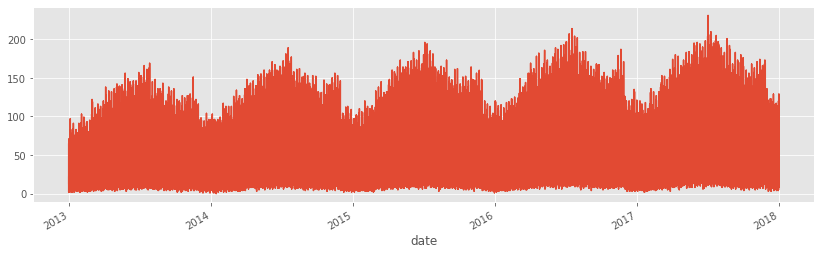

In [23]:
plt.figure(figsize=(14,4))
train.set_index('date')['sales'].plot(kind='line')

### 2.1 Sales

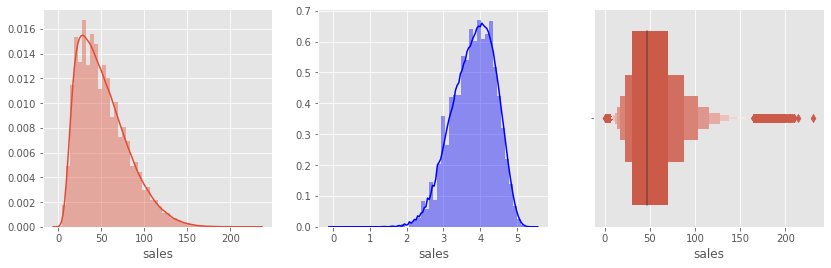

In [24]:
f,ax = plt.subplots(1,3,figsize=(14,4))
sns.distplot(train['sales'],ax =ax[0])
sns.distplot(np.log(train['sales']+1),ax=ax[1], color='b')
sns.boxenplot(train['sales'],ax =ax[2])

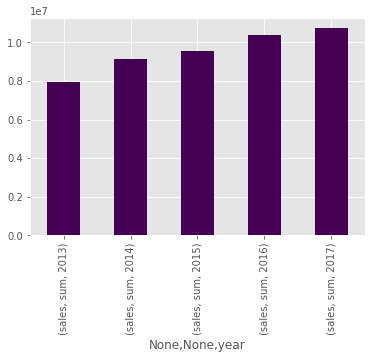

In [25]:
(train
 .groupby(['year',])
 .agg({'sales':['sum',]})
 .unstack()
 .plot(kind='bar',cmap='viridis'))

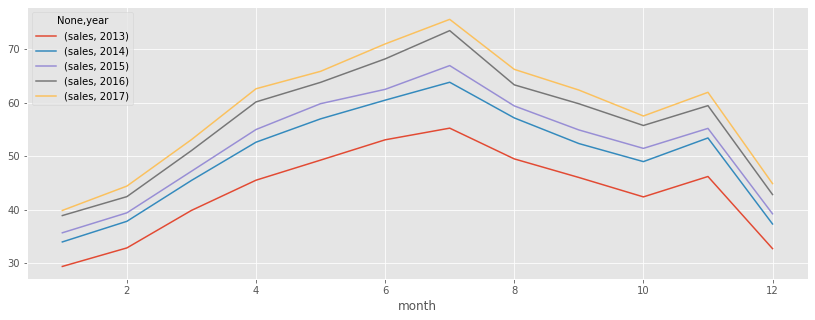

In [26]:
(train
 .groupby(['month','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

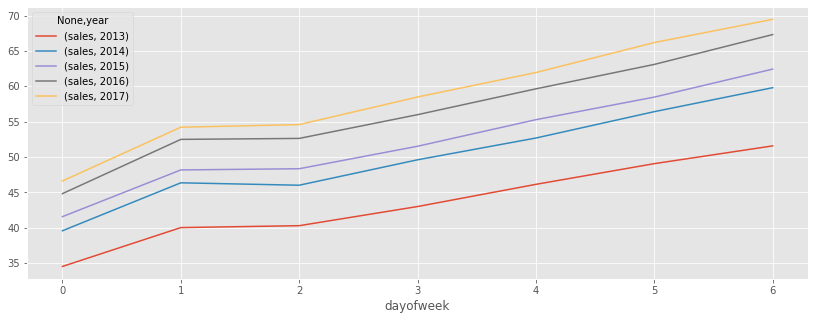

In [27]:
(train
 .groupby(['dayofweek','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

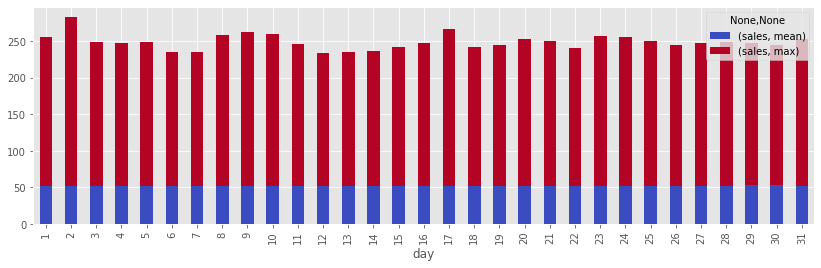

In [28]:
(train
.groupby(['day'])
.agg({'sales':['mean','max']})
.plot(figsize=(14,4),kind='bar',stacked=True,cmap='coolwarm'))

### 2.2 Aggregate sales statistics by day

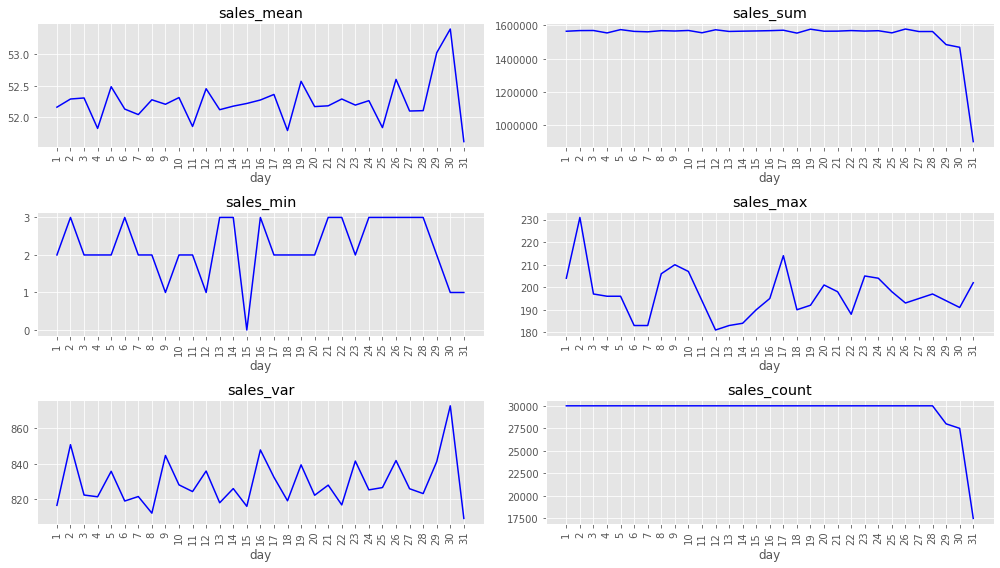

In [29]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['day'])

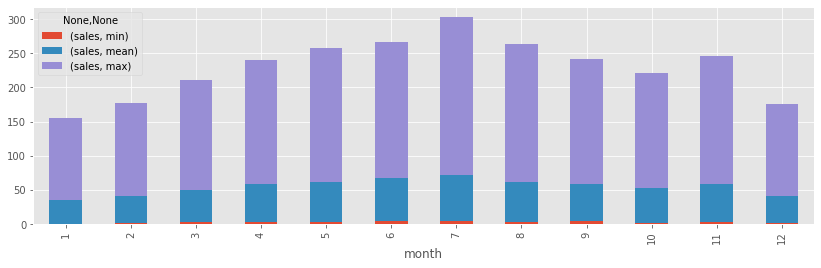

In [30]:
(train.groupby('month')
.agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True))

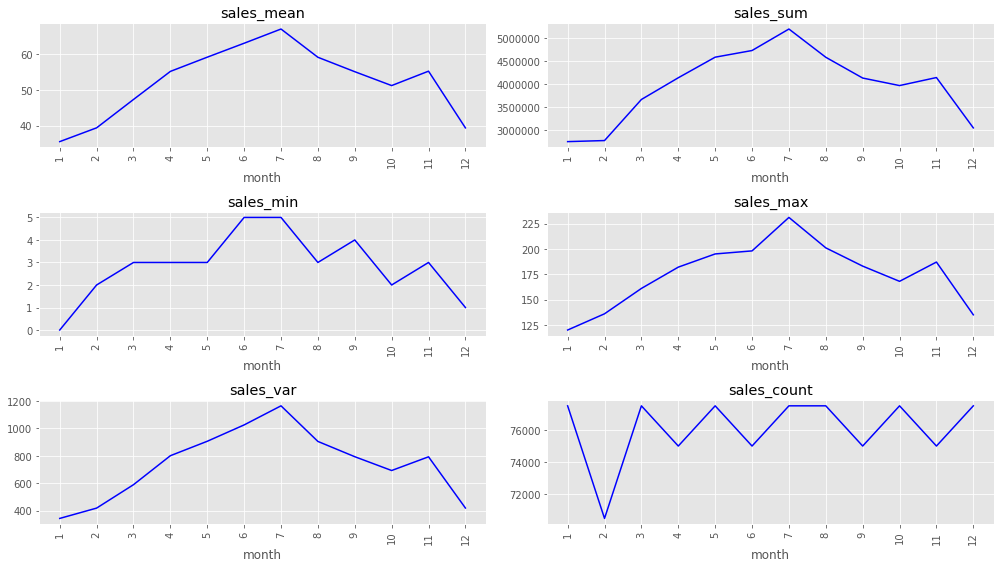

In [31]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['month'])

### 2.3 Store

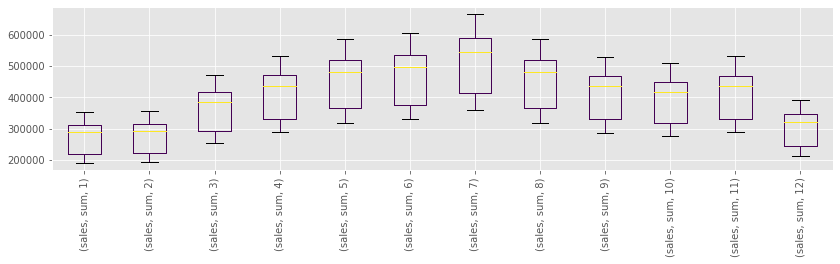

In [32]:
(train
 .groupby(['store','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

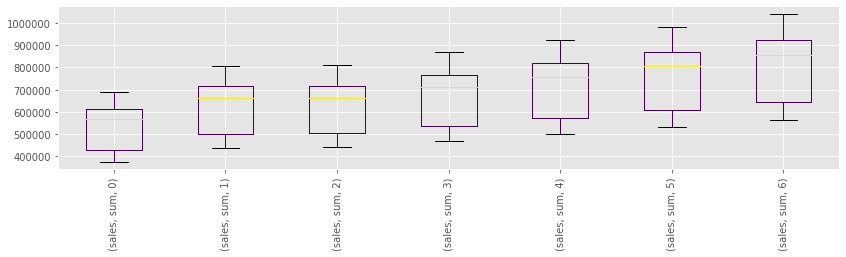

In [33]:
(train
 .groupby(['store','dayofweek'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

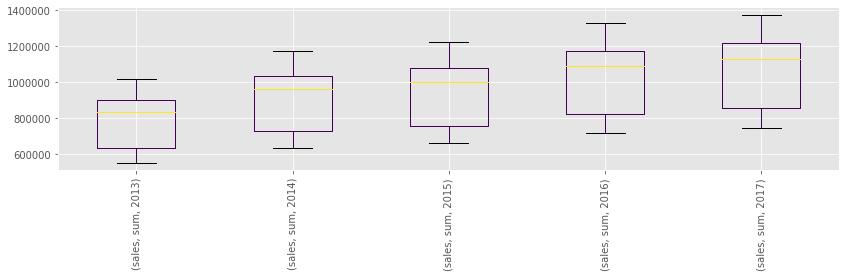

In [34]:
(train
 .groupby(['store','year'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

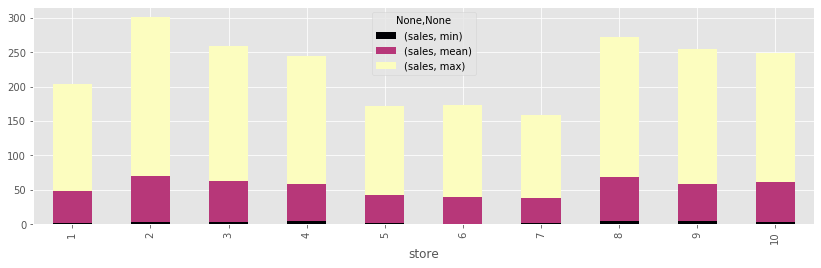

In [35]:
(train
 .groupby('store')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='magma'))

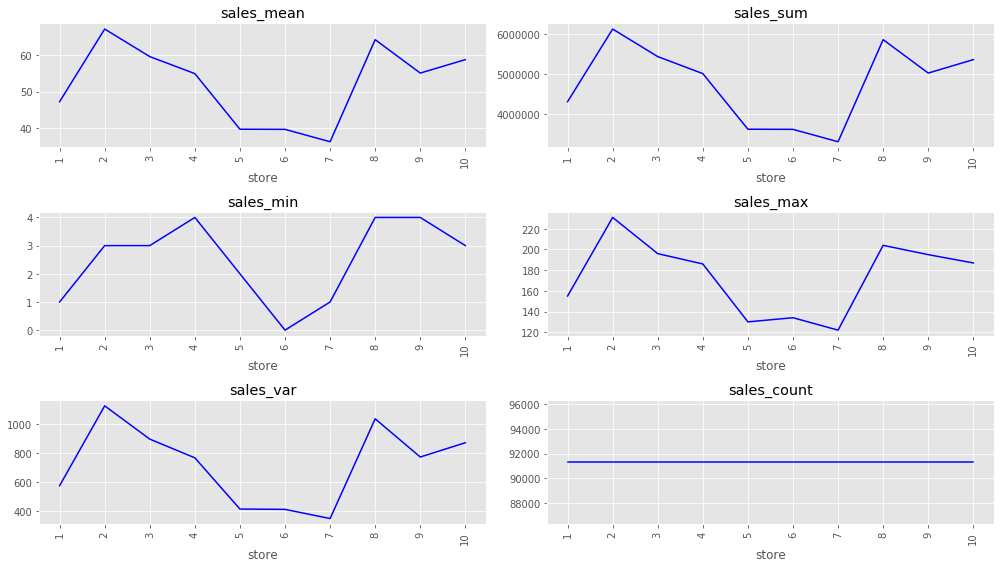

In [36]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['store'])

### 2.4 item

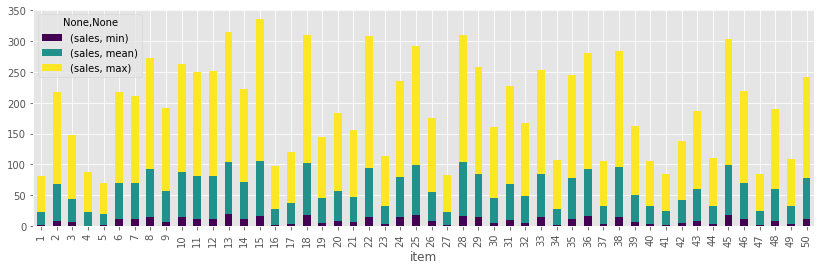

In [37]:
(train
 .groupby('item')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='viridis'))

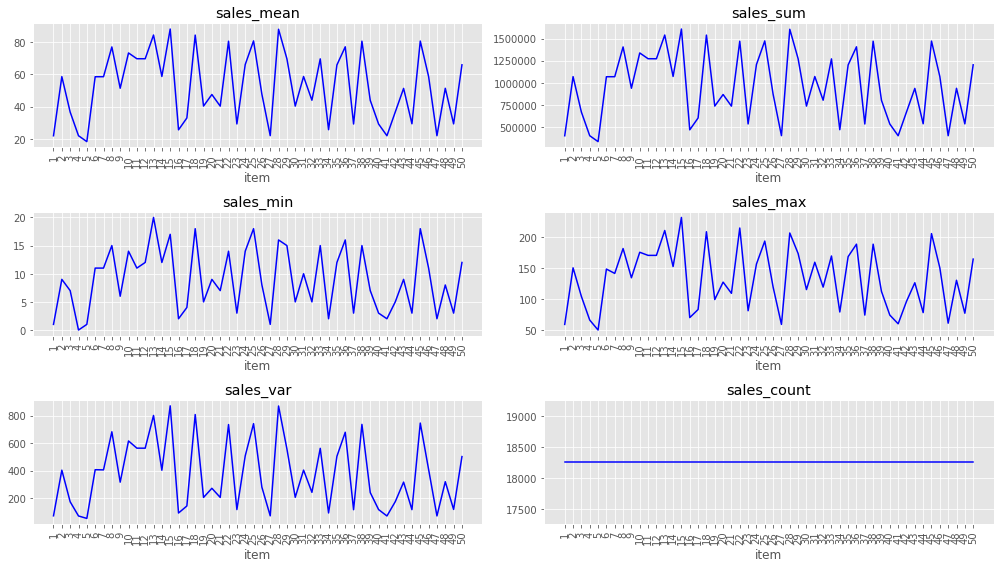

In [38]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['item'])

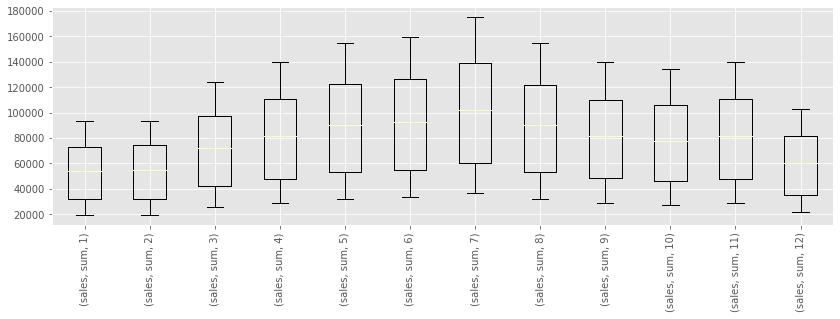

In [39]:
(train
 .groupby(['item','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='magma'))
plt.xticks(rotation=90);

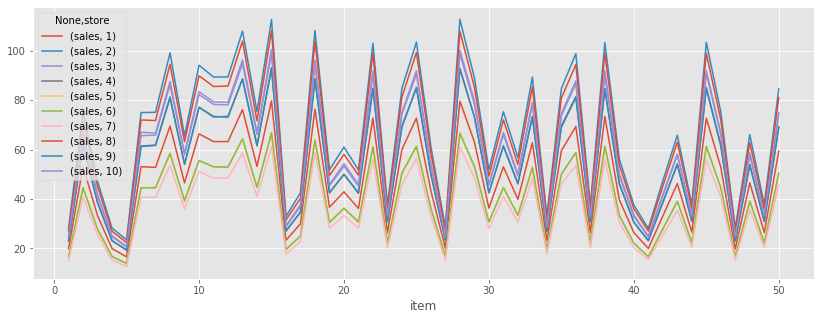

In [40]:
(train
 .groupby(['item','store'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5),kind='line'))
plt.savefig('agg.png')

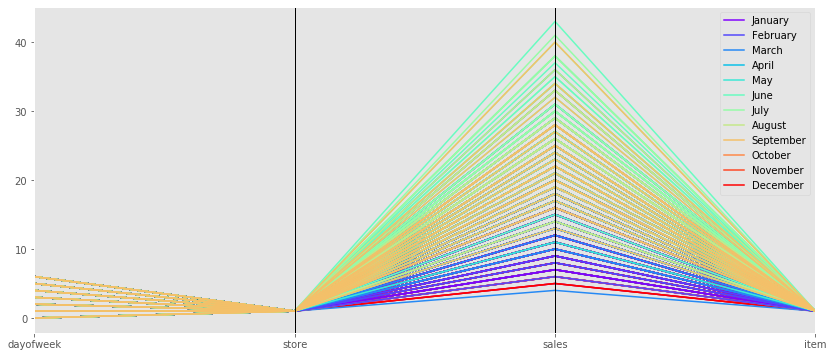

In [41]:
train1 =train.copy()
train1['month'] = train1['date'].dt.month_name()
plt.figure(figsize=(14,6))
pd.plotting.parallel_coordinates(train1[['dayofweek','store','sales','item','month']][:1000]
                                 ,'month',colormap='rainbow')
del train1

### 2.5 Rolling window

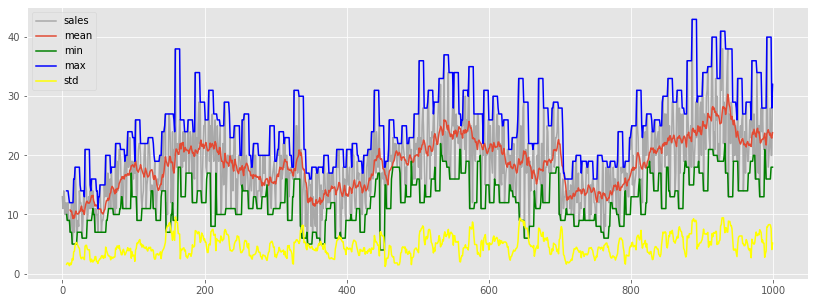

In [42]:
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).rolling(window=12).mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).rolling(window=7).min().plot(label='min',color='g')
train['sales'].head(1000).rolling(window=7).max().plot(label='max',color='b')
train['sales'].head(1000).rolling(window=7).std().plot(label='std',color='yellow')
plt.legend()
#plt.savefig('Rolling window.png')

### 2.6 Expanding window

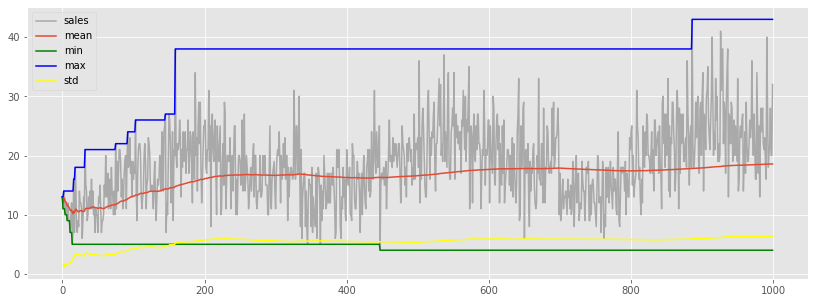

In [43]:
# Expanding window
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).expanding().mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).expanding().min().plot(label='min',color='g')
train['sales'].head(1000).expanding().max().plot(label='max',color='b')
train['sales'].head(1000).expanding().std().plot(label='std',color='yellow')
plt.legend()

## 3.0 Data preprocessing

### 3.0 Aggregate / Rolling function

In [44]:
# Claculate groupby statics for lag date 
def calc_stats(df, end,window,groupby=None,aggregates='mean',value='sales'):
    
    # dates
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days= window)
    # Aggregate
    df1 = df[(df.date >=first_date) & (df.date<= last_date) ]
    df_agg = df1.groupby(groupby)[value].agg(aggregates)
    # Change name of columns
    df_agg.name =  str(end).split(' ')[0]+'_' + '_'.join(groupby)+'_'+aggregates+'_'+ str(window)
    return df_agg.reset_index()

#sales_by_store_item
def sales_by_store_item(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item')
    data = calc_stats(df,end, window=1,aggregates=aggregates, 
                      groupby=['store','item'], value=value)
    print('window 1 added')
    
    for window in  [3,7,14,28,90,180,365]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['store','item'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

# sales by store item dayofweek
def sales_by_store_item_dayofweek(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item dayofweek')
    data = calc_stats(df,end, window=7, aggregates=aggregates,
                      groupby = ['store','item','dayofweek'], value=value)
    print('window 7 added')
    
    for window in  [14,28,28*2,28*3,28*6,28*12]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['store','item','dayofweek'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

# sales_by_store_item_day
def sales_by_store_item_day(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item day')
    data = calc_stats(df,end, window=365, aggregates=aggregates,
                      groupby = ['store','item','day'], value=value)
    print('window 365 added')
    
    return data

# Sales by item
def sales_by_item(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by item ')
    data = calc_stats(df,end, window=7, aggregates=aggregates,
                      groupby = ['item'], value=value)
    print('window 7 added')
    
    for window in  [14,28,28*2]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['item'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

In [45]:
def calc_roll_stat(df,end,groupby=None,window=1,aggregate='mean'):
    # Rolling statistics method
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days=window)
    df1 = df[(df.date >= first_date) & (df.date <= last_date)]
    
    dfPivot = df1.set_index(['date']+groupby)['sales'].unstack().unstack()
    dfPivot = dfPivot.rolling(window=window).mean().fillna(method='bfill')
    return dfPivot.stack().stack().rename(aggregate+str(window))

def calc_expand_stat(df,end,window=1,aggregate='mean'):
    # Expanding statistics method
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days=window)
    df1 = df[(df.date >= first_date) & (df.date <= last_date)]
    
    dfPivot = df1.set_index(['date','store','item'])['sales'].unstack().unstack()
    dfPivot = dfPivot.expanding(min_periods=window).mean().fillna(method='bfill')
    dfPivot = dfPivot.stack().stack().rename(aggregate+'_'+str(window)).reset_index()
    return dfPivot

def sales_by_store_item_expading(df,end,aggregate = 'mean', value = 'sales'):
    print('Adding sales by expanding')
    data =calc_expand_stat(df,end,window=3, aggregate='mean')
    return data
# https://stackoverflow.com/questions/25917287/pandas-groupby-expanding-mean-by-column-value

In [46]:
def create_data1(sales,test,date):
    
    # Date input
    for i in range(2):
        end = pd.to_datetime(date) - pd.Timedelta(days=7*i+1)
        print(end)
    
        # Rolling feature
        #for aggregates in ['mean','min','max','sum','std']:
        for aggregates in ['mean','sum']:

            # store/item
            print('-'*20+'Aggregate by '+aggregates+'-'*20)
            data = sales_by_store_item(sales,end, aggregates=aggregates,value='sales')
            sales = pd.merge(sales,data,on=['store','item'],how='left')
            test = pd.merge(test,data,on=['store','item'], how='left')

            # store/item/dayofweek
            df = sales_by_store_item_dayofweek(sales,end, aggregates=aggregates,value='sales')
            #data = pd.merge(data,df,)
            sales = pd.merge(sales,df,on=['store','item','dayofweek'],how='left')
            test = pd.merge(test,df,on=['store','item','dayofweek'], how='left')

            # store/item/day
            df = sales_by_store_item_day(sales,end, aggregates=aggregates,value='sales')
            #data = pd.merge(data,df)
            sales = pd.merge(sales,df,on=['store','item','day'],how='left')
            test = pd.merge(test,df,on=['store','item','day'], how='left')

            # sales/item
            df = sales_by_item(sales,end, aggregates=aggregates, value='sales')
            data = pd.merge(data,df)
            #data = pd.merge(sales,data)
            sales = pd.merge(sales,df, on=['item'],how='left')
            test = pd.merge(test,df, on=['item'], how='left')

    return sales,test

In [47]:
#Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
#Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"
tes_start = '2018-01-01'

In [48]:
# Rolling aggregation or lag feature for diffirend window size
train1,test1 = create_data1(train,test,tes_start)

2017-12-31 00:00:00
--------------------Aggregate by mean--------------------
Adding sales by store item
window 1 added
window 3 added
window 7 added
window 14 added
window 28 added
window 90 added
window 180 added
window 365 added
Adding sales by store item dayofweek
window 7 added
window 14 added
window 28 added
window 56 added
window 84 added
window 168 added
window 336 added
Adding sales by store item day
window 365 added
Adding sales by item 
window 7 added
window 14 added
window 28 added
window 56 added
--------------------Aggregate by sum--------------------
Adding sales by store item
window 1 added
window 3 added
window 7 added
window 14 added
window 28 added
window 90 added
window 180 added
window 365 added
Adding sales by store item dayofweek
window 7 added
window 14 added
window 28 added
window 56 added
window 84 added
window 168 added
window 336 added
Adding sales by store item day
window 365 added
Adding sales by item 
window 7 added
window 14 added
window 28 added
window 

### 3.1 One hot encoding

In [49]:
train1['id'] = np.nan
train1['is_train'] = True
test1['is_train'] = False
test1['sales'] = np.nan

# concat train,test
train_test = pd.concat([train1,test1],axis=0)

#Log transform
train_test['sales_log'] = np.log(train_test['sales']+1)
gc.collect()
train_test.shape

def one_hot_encoding(df,columns):
    print('Original shape',df.shape)
    df = pd.get_dummies(df,drop_first=True,columns=columns)
    print('After OHE', df.shape)
    return df

In [50]:
gc.collect()
train_test = one_hot_encoding(train_test,columns=['month','dayofweek'])

Original shape (958000, 94)
After OHE (958000, 109)


In [51]:
reduce_memory_usage(train_test)

Intial memory usage: 676.0787963867188 MB
Memory usage after complition:  533.5540771484375 MB


In [52]:
#plt.figure(figsize=(14,10))
#sns.heatmap(train_test1.corr(), cmap='coolwarm', annot=True,fmt='.2f')

## 4.0 Model selection

In [53]:
# Model
col_drop = ['id','is_train','sales','sales_log']
X = train_test[train_test['is_train'] == True].drop(col_drop, axis=1)
y = train_test[train_test['is_train'] == True]['sales_log']
test_new = train_test[train_test['is_train'] == False].drop(col_drop +['date'],axis=1)

# Time series based split
#Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
#Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"
tra_start, tra_end = '2013-01-01','2016-12-31'
val_start, val_end = '2017-01-01','2017-12-31'
tes_start = '2018-01-01'

X_train = X[X.date.isin(pd.date_range(tra_start,tra_end))].drop(['date'],axis=1)
X_valid = X[X.date.isin(pd.date_range(val_start, val_end))].drop(['date'],axis=1)
y_train = y[X.date.isin(pd.date_range(tra_start,tra_end))]
y_valid = y[X.date.isin(pd.date_range(val_start, val_end))]
gc.collect()
X.shape,test_new.shape

((913000, 105), (45000, 104))

In [54]:
# SMAPE Systematic mean absolute Persent error
def smape(y_true,y_pred):
    
    n = len(y_pred)
    masked_arr = ~((y_pred==0)&(y_true==0))
    y_pred, y_true = y_pred[masked_arr], y_true[masked_arr]
    nom = np.abs(y_true - y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    smape = 200/n * np.sum(nom/denom)
    return smape
def lgb_smape(pred,train_data):
    ''' 
    Custom evaluvation function
    '''
    label = train_data.get_label()
    smape_val = smape(np.expm1(pred), np.expm1(label))
    return 'SMAPE',smape_val, False

In [55]:
import sklearn
from sklearn.metrics import r2_score
def rscore(y_true,y_pred):
    return sklearn.metrics.r2_score(y_true, y_pred)
    
def lgb_rscore(pred,train_data):
    ''' 
    Custom evaluvation function
    '''
    label = train_data.get_label()
    rscore_val = rscore(np.expm1(pred), np.expm1(label))
    return 'RSCORE',rscore_val, False

In [56]:
import sklearn
from sklearn.metrics import r2_score

## 5.0 Model

In [57]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(X_train, y_train)
predict1 = model1.predict(X_valid)

In [58]:
y_pred_new=test_predict = model1.predict(test_new)
y_pred = model1.predict(X_valid)
print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred))

rscore is 0.8859449512360421


In [59]:
test_new

,store,item,day,year,is_month_end,is_month_start,weekofyear,2017-12-31_store_item_mean_1,2017-12-31_store_item_mean_3,2017-12-31_store_item_mean_7,...,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,1,1,1,2018,0,1,1,27,20.333334,17.571428,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,2018,0,0,1,27,20.333334,17.571428,...,0,0,0,0,1,0,0,0,0,0
2,1,1,3,2018,0,0,1,27,20.333334,17.571428,...,0,0,0,0,0,1,0,0,0,0
3,1,1,4,2018,0,0,1,27,20.333334,17.571428,...,0,0,0,0,0,0,1,0,0,0
4,1,1,5,2018,0,0,1,27,20.333334,17.571428,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,10,50,27,2018,0,0,13,62,65.000000,60.857143,...,0,0,0,0,1,0,0,0,0,0
44996,10,50,28,2018,0,0,13,62,65.000000,60.857143,...,0,0,0,0,0,1,0,0,0,0
44997,10,50,29,2018,0,0,13,62,65.000000,60.857143,...,0,0,0,0,0,0,1,0,0,0
44998,10,50,30,2018,0,0,13,62,65.000000,60.857143,...,0,0,0,0,0,0,0,1,0,0


## 5.0 Model

In [62]:
def lgb_model(X_train, X_valid, y_valid, y_test,test_new):
    lgb_param = {}
    lgb_param['boosting_type'] ='gbdt'
    lgb_param['max_depth'] = 7
    lgb_param['num_leaves'] = 2**7
    lgb_param['learning_rate'] = 0.05
    #lgb_param['n_estimators'] = 3000
    lgb_param['feature_fraction'] = 0.9
    lgb_param['bagging_fraction'] = 0.9
    lgb_param['lambda_l1'] = 0.06
    lgb_param['lambda_l2'] =  0.1
    lgb_param['random_state'] = seed
    lgb_param['n_jobs'] = 4
    lgb_param['silent'] = -1
    lgb_param['verbose'] = -1
    lgb_param['metric'] = 'mae'
    
    model = lgb.LGBMRegressor(**lgb_param)
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_valid = lgb.Dataset(X_valid,y_valid)
    valid_set = [lgb_train,lgb_valid]
    #model = lgb.train(params=lgb_param,train_set=lgb_train,valid_sets=valid_set,num_boost_round= 300,
    #                  feval=lgb_rscore,early_stopping_rounds=20,)
    model = lgb.train(params=lgb_param,train_set=lgb_train,valid_sets=valid_set,num_boost_round= 300,
                      feval=lgb_smape,early_stopping_rounds=20,)
    print('-'*10,'*'*20,'-'*10)
    #model.fit(X_train,y_train, eval_set= [(X_train,y_train),(X_valid,y_valid)],
    #          eval_metric ='rmse',early_stopping_rounds=20,verbose=100)
    
    y_pred = model.predict(X_valid)
    print('Root mean_squared_error','-'*20 ,np.sqrt(mean_squared_error(y_valid, y_pred)))
    print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred))
    y_pred_new = model.predict(test_new)
    #print("rscore is",sklearn.metrics.r2_score(y_valid, y_pred_new))
    return y_pred_new, model

In [63]:
# Model training
y_pred_new, model = lgb_model(X_train, X_valid, y_valid, y_valid,test_new)

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\basic.py:794: UserWarning:

silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.



[1]	training's l1: 0.449862	training's SMAPE: 44.0816	valid_1's l1: 0.467346	valid_1's SMAPE: 45.697
Training until validation scores don't improve for 20 rounds
[2]	training's l1: 0.429565	training's SMAPE: 42.2474	valid_1's l1: 0.447381	valid_1's SMAPE: 43.8937
[3]	training's l1: 0.410545	training's SMAPE: 40.5112	valid_1's l1: 0.428788	valid_1's SMAPE: 42.2004
[4]	training's l1: 0.393274	training's SMAPE: 38.9201	valid_1's l1: 0.411537	valid_1's SMAPE: 40.6123
[5]	training's l1: 0.376008	training's SMAPE: 37.318	valid_1's l1: 0.394522	valid_1's SMAPE: 39.0348
[6]	training's l1: 0.359659	training's SMAPE: 35.7897	valid_1's l1: 0.378467	valid_1's SMAPE: 37.5354
[7]	training's l1: 0.344287	training's SMAPE: 34.3437	valid_1's l1: 0.363483	valid_1's SMAPE: 36.1288
[8]	training's l1: 0.329893	training's SMAPE: 32.9806	valid_1's l1: 0.349582	valid_1's SMAPE: 34.8166
[9]	training's l1: 0.316123	training's SMAPE: 31.6693	valid_1's l1: 0.335708	valid_1's SMAPE: 33.4981
[10]	training's l1: 0.3

[81]	training's l1: 0.124982	training's SMAPE: 12.8355	valid_1's l1: 0.123398	valid_1's SMAPE: 12.6155
[82]	training's l1: 0.124937	training's SMAPE: 12.831	valid_1's l1: 0.123232	valid_1's SMAPE: 12.5988
[83]	training's l1: 0.124895	training's SMAPE: 12.8268	valid_1's l1: 0.123098	valid_1's SMAPE: 12.5853
[84]	training's l1: 0.124855	training's SMAPE: 12.8228	valid_1's l1: 0.122937	valid_1's SMAPE: 12.5692
[85]	training's l1: 0.124819	training's SMAPE: 12.8192	valid_1's l1: 0.122797	valid_1's SMAPE: 12.5551
[86]	training's l1: 0.124785	training's SMAPE: 12.8159	valid_1's l1: 0.122675	valid_1's SMAPE: 12.5429
[87]	training's l1: 0.124752	training's SMAPE: 12.8126	valid_1's l1: 0.122547	valid_1's SMAPE: 12.53
[88]	training's l1: 0.124721	training's SMAPE: 12.8095	valid_1's l1: 0.122443	valid_1's SMAPE: 12.5196
[89]	training's l1: 0.124693	training's SMAPE: 12.8068	valid_1's l1: 0.122338	valid_1's SMAPE: 12.509
[90]	training's l1: 0.124665	training's SMAPE: 12.804	valid_1's l1: 0.122239	

[161]	training's l1: 0.123891	training's SMAPE: 12.7265	valid_1's l1: 0.120229	valid_1's SMAPE: 12.2974
[162]	training's l1: 0.123882	training's SMAPE: 12.7256	valid_1's l1: 0.120217	valid_1's SMAPE: 12.2962
[163]	training's l1: 0.123872	training's SMAPE: 12.7246	valid_1's l1: 0.120217	valid_1's SMAPE: 12.2961
[164]	training's l1: 0.123864	training's SMAPE: 12.7239	valid_1's l1: 0.120218	valid_1's SMAPE: 12.2962
[165]	training's l1: 0.123858	training's SMAPE: 12.7232	valid_1's l1: 0.120204	valid_1's SMAPE: 12.2948
[166]	training's l1: 0.123853	training's SMAPE: 12.7227	valid_1's l1: 0.120204	valid_1's SMAPE: 12.2948
[167]	training's l1: 0.123845	training's SMAPE: 12.7219	valid_1's l1: 0.120202	valid_1's SMAPE: 12.2946
[168]	training's l1: 0.12384	training's SMAPE: 12.7213	valid_1's l1: 0.120197	valid_1's SMAPE: 12.2942
[169]	training's l1: 0.123832	training's SMAPE: 12.7206	valid_1's l1: 0.120196	valid_1's SMAPE: 12.294
[170]	training's l1: 0.123826	training's SMAPE: 12.72	valid_1's l1

Root mean_squared_error -------------------- 0.15497861699936316
rscore is 0.9253936639400002


### 6.0 Model evaluation

In [64]:
#print('Root mean_squared_error',np.sqrt(mean_squared_error(y_test, y_pred)))

In [65]:
#182500, 45000]

In [66]:
#len(y_valid)
#len(X_valid)

In [67]:
#len(X_valid)

In [68]:
#len(test_new)

In [69]:
#len(test1)

In [70]:
#len(y_valid)

In [71]:
#print(y_valid.shape)

In [72]:
#print(y_pred_new.shape)

In [73]:
#len(y_pred)

In [74]:
#len(y_pred_new)#

In [75]:
#len(X_train)

In [76]:
#print("rscore is",sklearn.metrics.r2_score(y_valid,y_pred_new))

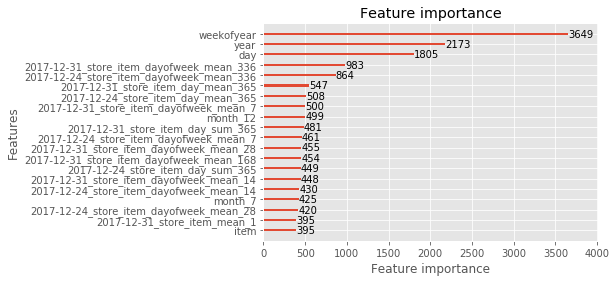

In [77]:
# Feature importance
lgb.plot_importance(model,max_num_features=20);

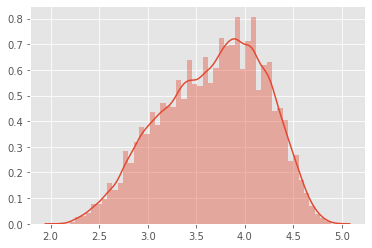

In [78]:
sns.distplot(y_pred_new)

## END OF LGBM MODEL


In [79]:
## 

##    ARIMA MODEL 
                                                            

Import the packages

In [80]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore') #to ignore if any warnings takes place during the run time.
#import statsmodels.api as sm
import os
os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")

In [81]:
#read the data
df=pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [82]:
#check for missing values in train data
 df.isnull().sum()
 #No missing valuues



date     0
store    0
item     0
sales    0
dtype: int64

Here for better understanding of the data, We can eloborate as month and weekday wise.

In [83]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d") #If need extract year, month and day to new columns:

# per 1 store, 1 item
train_df = df[df['store']==1]
train_df = train_df[df['item']==1]

# train_df = train_df.set_index('date')
train_df['year'] = df['date'].dt.year
train_df['month'] = df['date'].dt.month
train_df['day'] = df['date'].dt.dayofyear
train_df['weekday'] = df['date'].dt.weekday

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


Below plots are for checking the seasonality, trends and outliers.

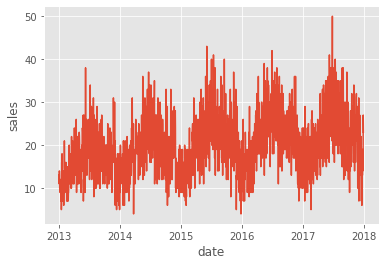

In [84]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

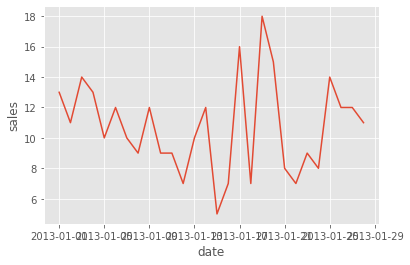

In [85]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

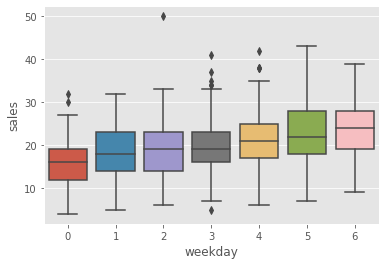

In [86]:
sns.boxplot(x="weekday", y="sales", data=train_df)

In [87]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


**Time series decomposition**

Think of the time series ytyt as consisting of three components: a seasonal component, a trend-cycle component (containing both trend and cycle), and a remainder component (containing anything else in the time series).
1. Additive model
1. Multiplicative model

The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series.

When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate.

**play this quiz you will come familiar with additive or multiplicative** https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/ 


**Should I use an additive model or a multiplicative model?**

Choose the multiplicative model when the magnitude of the seasonal pattern in the data depends on the magnitude of the data. In other words, the magnitude of the seasonal pattern increases as the data values increase, and decreases as the data values decrease.
Choose the additive model when the magnitude of the seasonal pattern in the data does not depend on the magnitude of the data. In other words, the magnitude of the seasonal pattern does not change as the series goes up or down.
If the pattern in the data is not very obvious, and you have trouble choosing between the additive and multiplicative procedures, you can try both and choose the one with smaller accuracy measures.



<Figure size 432x288 with 0 Axes>

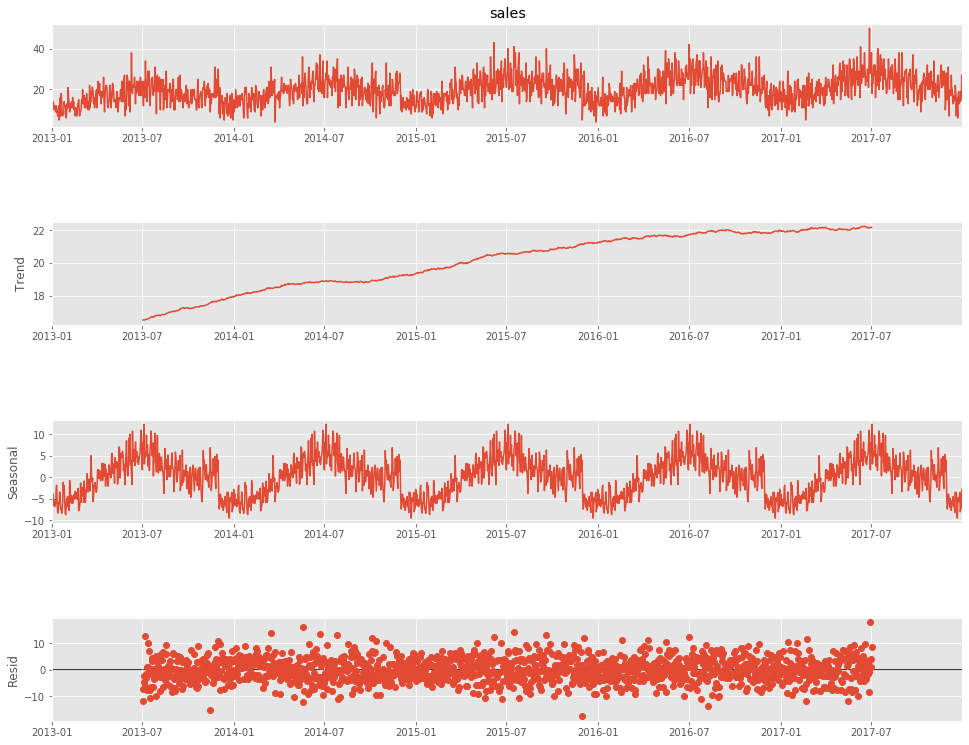

In [90]:

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)


 The yearly pattern is very obvious. and also we can see a upwards trend. Which means this data is not stationary.



In [91]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    
  #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    fig= plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='orange',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    
      #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
   
    
    

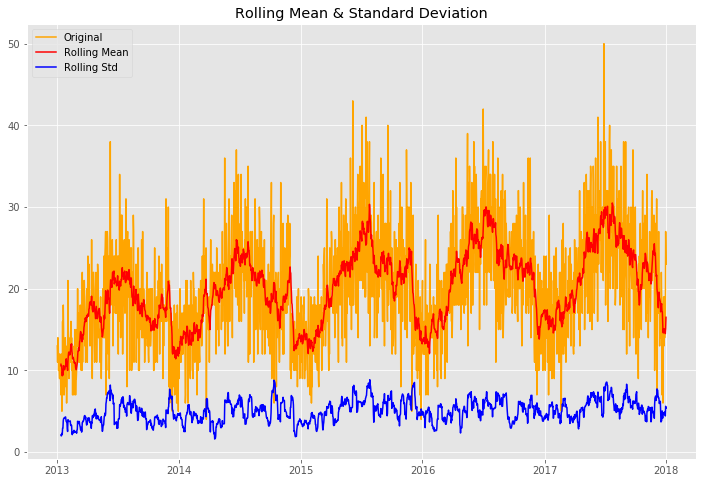

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [92]:
test_stationarity(train_df['sales'])

**How to find whether our data is stationary or not ?**

the smaller p-value, the more likely it's stationary. Here our p-value is 0.036. It's actually not bad, if we use a 5% Critical Value(CV), this series would be considered stationary. But as we just visually found an upward trend, we want to be more strict, we use 1% CV.
To get a stationary data, there's many techiniques. We can use log, differencing etc...

**NOTE**

If the **p-value** is less than 5%(significance level) or If the **Test Static** value is greater than than the **Critical value** than our data is stationary

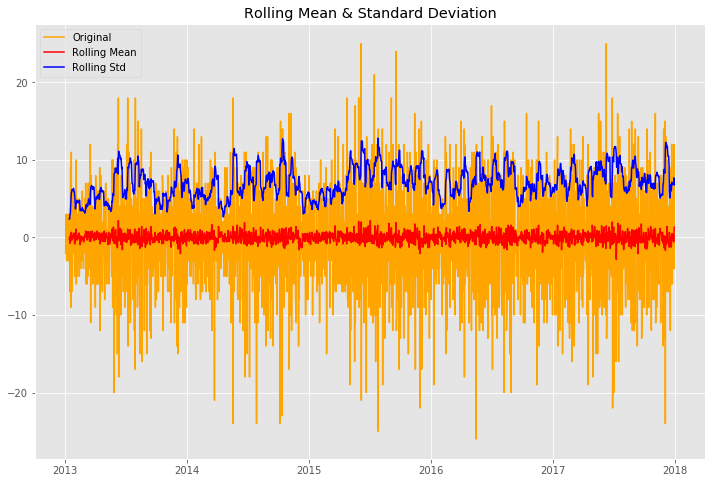

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [93]:
#this is for reducing trend and seasonality
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

**ACF (Auto Corelation Function) and (Partial Auto Corelation Function)**

 **What is ACF ?**
 
 For Instance today stock price we predicted based on yesterday stock price the ACF will tell how much strongly they are corelated, If todays value is depended on day before yesterday than ACF will tell how strong they are and how many days required to predict the todays value.
 
 **What is PACF?**
 
 If we want to calculate the corelation between today and yesterday we have to take the corelation of day before yesterday because todays value depends upon the yesterday time spot. So this is the reason we use PACF.

  ** PACF- AR model**
   
   **ACF- MA model**
   
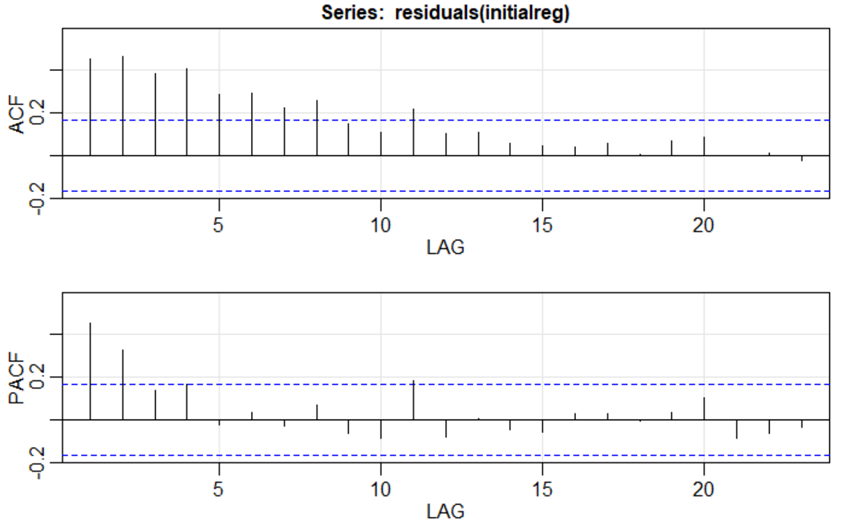

by the above images we can observe that, the lines which crosses the blue dotted lines in PACF and ACF those lines are considered to be that many days are required to predict the todays value. **For example in above PACF plot that has only three lines which crossed the blue dotted lines so last three days values are required to predict the todays value**, similarly ACF plot also but for model we should not consider ACF-MA model because many lines crossed the blue threshold line, so it will create the model complex. So we should select only PACF-AR model to predict

   ***if you want to know more about PACF and ACF go through this link***     https://www.youtube.com/watch?v=5Q5p6eVM7zM

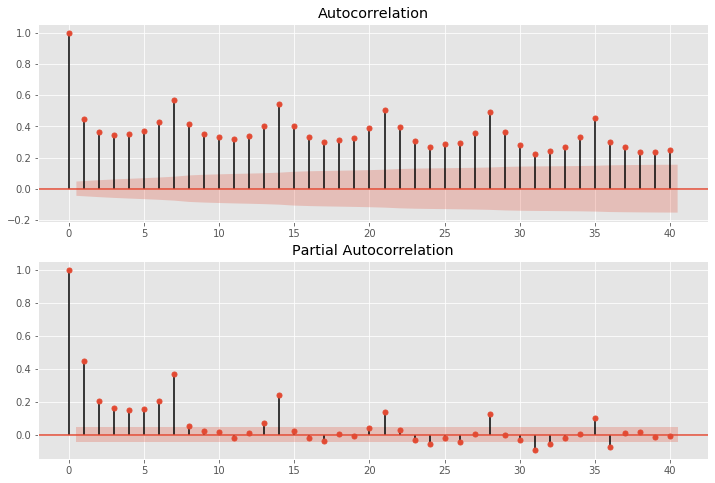

In [94]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)      #lags=40

By seeing the above plots, there are lots of significant plots so as previously i explained if more lines crossed the blue line, than the model will get complex so go for the first difference. 

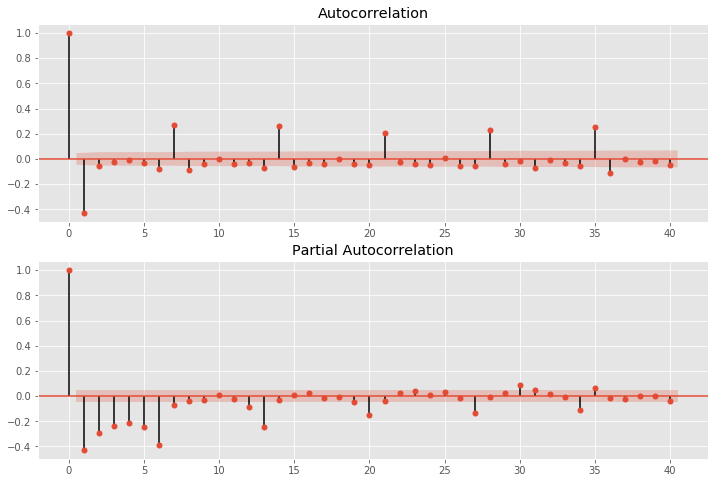

In [95]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 
# Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of 
# significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont


**How to determin p, d, q**

It's easy to determin I. In our case, we see the first order differencing make the **ts stationary. I = 1.**

In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use **AR = 6 (6 lines are crossed the blue lines so 6past days are required to predict)**

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [96]:
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Sat, 20 Mar 2021   AIC                          11211.335
Time:                        10:53:25   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

**Analyze the result**

To see how our first model perform, we can plot the residual distribution. See if it's normal dist. And the ACF and PACF. For a good model, we want to see the residual is normal distribution. And ACF, PACF has not significant terms.



NormaltestResult(statistic=16.426385419902807, pvalue=0.00027105394172084377)


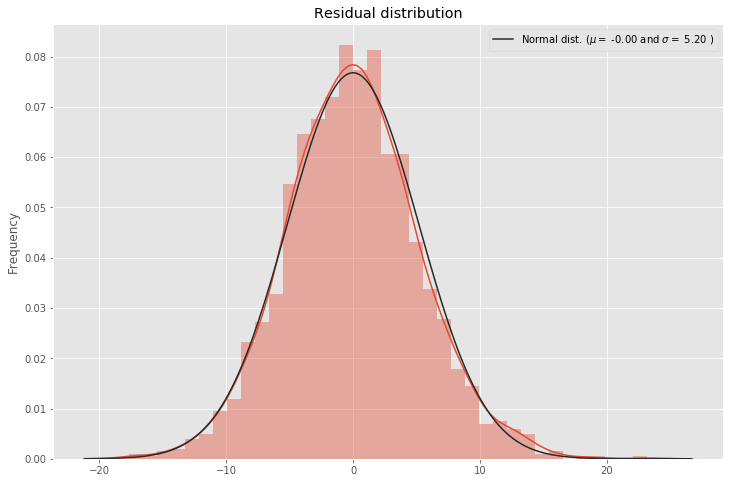

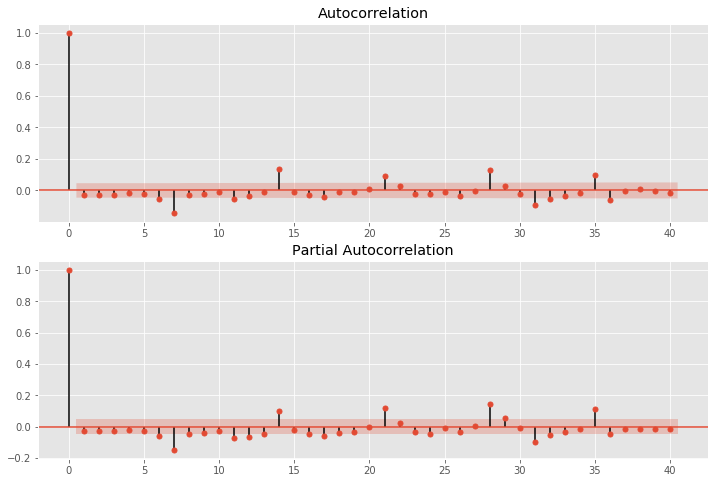

In [97]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality.

When the plots of ACF and PACF are similar or any sesaonality is present between them than we need to apply **SARIMA** model, which it is extended model of **ARIMA**

**What is SARIMA and what is the use of it ?**

ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting, but it does not support time series with a seasonal component. The ARIMA model is extended (SARIMA) to support the seasonal component of the series. SARIMA (Seasonal Autoregressive Integrated Moving Average), method for time series forecasting is used on univariate data containing trends and seasonality. SARIMA is composed of trend and seasonal elements of the series.

Some of the parameters that are same as ARIMA model are:
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order
There are four seasonal elements that are not part of ARIMA are:
P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.
Thus SARIMA model can be specified as:
SARIMA (p, d, q) (P,D,Q) m

If m is 12, it specifies monthly data suggests a yearly seasonal cycle.
SARIMA time series models can also be combined with spatial and event based models to yield ensemble models that solves multi-dimensional ML problems. Such a ML model can be designed to predict cell load in cellular networks at different times of the day round the year as illustrated below in the sample figure
Autocorrelation, trend, and seasonality (weekday , weekend effects) from time series analysis can be used to interpret temporal influence.
Regional and cell wise load distribution can be used to predict sparse and over loaded cells in varying intervals of time.
Events (holidays, special mass gatherings and others) can be predicted using decision trees.

**Reference :**

https://towardsdatascience.com/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-series-data-509a5d87f20a



In [98]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Sat, 20 Mar 2021   AIC                          11209.359
Time:                        10:53:26   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

******

NormaltestResult(statistic=16.742690150191912, pvalue=0.00023140408843648014)


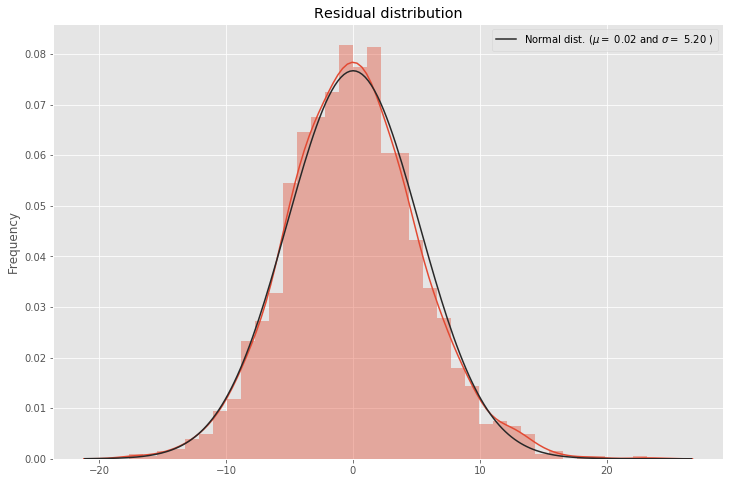

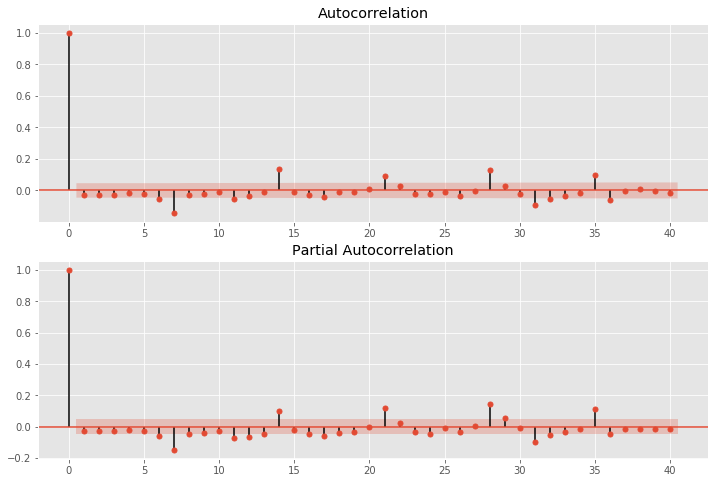

In [99]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

**Make prediction and evaluation**

Take the last 30 days in training set as validation data



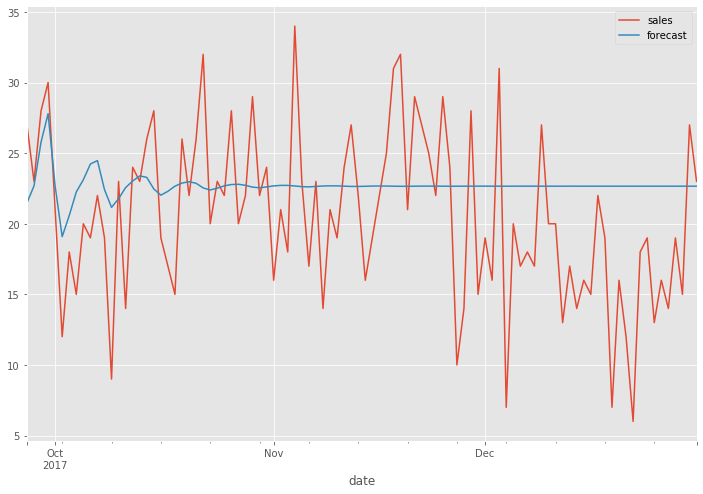

In [100]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

**Evaluations of the model**

In [101]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [102]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


**Conclusion**

The study concludes with some case studies why specific machine learning methods perform so poorly in practice, given their impressive performance in other areas of artificial intelligence.
The challenge leaves it open to evaluate reasons of poor performance for ARIMA/SARIMA and LSTM models, and devise mechanisms to improve model’s poor performance and accuracy. Some of the areas of application of the models and their performance is listed below:

ARIMA yields better results in forecasting short term, whereas LSTM yields better results for long term modeling.
Traditional time series forecasting methods (ARIMA) focus on univariate data with linear relationships and fixed and manually-diagnosed temporal dependence.
Machine learning problems with substantial dataset, its found that the average reduction in error rates obtained by LSTM is between 84–87 percent when compared to ARIMA indicating the superiority of LSTM to ARIMA.

The number of training times, known as “epoch” in deep learning, has no effect on the performance of the trained forecast model and it exhibits a truly random behavior.

LSTMs when compared to simpler NNs like RNN and MLP appear to be more suited at fitting or overfitting the training dataset rather than forecasting it.

Neural networks (LSTMs and other deep learning methods) with huge datasets offer ways to divide it into several smaller batches and train the network in multiple stages. 
The batch size/each chunk size refers to the total number of training data used. The term iteration is used to represent number of batches needed to complete training a model using the entire dataset.

LSTM is undoubtedly more complicated and difficult to train and in most cases do not exceed the performance of a simple ARIMA model.





## part B

### SOURCING AND OUTSOURCING 


In [136]:
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

lat1 = 40.5; lat2 = 42; long1 = -90; long2 = -93
print( distance((lat1, long1), (lat2, long2)) )


301.17000641409464


In [137]:
#Data Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import folium
import calmap
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_dark"

#Some styling
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

#displaying markdown
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

#Web scraping tools
#REQUESTS --> to fetch data from website
import requests
import json

#BEAUTIFULSOUP  -->parse HTML content 
from bs4 import BeautifulSoup  

#Showing full path of datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [138]:
import pandas  as  pd 
import  numpy  as  np
import  seaborn  as  sns 
import  matplotlib.pyplot  as  plt 
%matplotlib inline
from  datetime  import  datetime 
from  time  import  time 
from  datetime  import  timedelta
import os
import itertools


In [139]:
os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")

In [140]:
df = pd.read_csv('available_products.csv')
df.head()

,Pune,Delhi
0,brakes,tyre
1,fuel_pump,brakes
2,tyre,v4


In [141]:
part = input("enter a product name ")

enter a product name brakes


In [142]:
def search(part):
    if part in df.values : 
        return df.columns
    else : 
        print("\nThis value does not exists in Dataframe") 

In [143]:
a=search(part)
print(a)

Index(['Pune', 'Delhi'], dtype='object')


In [144]:
def search(part):
    lst=[]
    for (columnName, columnData) in df.iteritems():
        if part in columnData.values : 
            lst.append(columnName)
    return(lst)

 

In [145]:
a=search(part)
print(a)
print(part)

['Pune', 'Delhi']
brakes


In [146]:
distance=pd.read_csv('district wise centroids.csv')
distance.head()

,State,District,Latitude,Longitude
0,Andaman and Nicobar,Andaman Islands,12.382571,92.822911
1,Andaman and Nicobar,Nicobar Islands,7.835291,93.511601
2,Andhra Pradesh,Adilabad,19.284514,78.813212
3,Andhra Pradesh,Anantapur,14.312066,77.460158
4,Andhra Pradesh,Chittoor,13.331093,78.927639


In [147]:
distance['Longitude']

0      92.822911
1      93.511601
2      78.813212
3      77.460158
4      78.927639
         ...    
589    88.877940
590    86.396853
591    88.445370
592    88.235952
593    87.231014
Name: Longitude, Length: 594, dtype: float64

In [148]:
distance[distance["District"]=='Pune'] 

,State,District,Latitude,Longitude
328,Maharashtra,Pune,18.516962,74.129229


In [149]:
#distance.loc(distance[distance['District'] == location])

In [150]:
e=pd.DataFrame()
latitudes=[]
longitudes=[]
locations=[]

In [151]:
for i in range(len(a)):
    location=a[i]
    e=distance[distance['District'] == location]
    latitudes.append(list(e["Latitude"]))
    longitudes.append(list(e["Longitude"]))
    locations.append(list(e["District"]))
    
    
#c['Latitude']

In [152]:
longitudes

[[74.12922881632646], [77.1280451754386]]

In [153]:
latitudes


[[18.51696171428573], [28.64594429824561]]

In [154]:
latitude = latitudes
  
# output list 
latitudes = [] 
  
# function used for removing nested  
# lists in python.  
def reemovNestings(latitude): 
    for i in latitude: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            latitudes.append(i) 
  
# Driver code 
print ('The original list: ', latitude) 
reemovNestings(latitude) 
print ('The list after removing nesting: ', latitudes) 

The original list:  [[18.51696171428573], [28.64594429824561]]
The list after removing nesting:  [18.51696171428573, 28.64594429824561]


In [155]:
longitude = longitudes
  
# output list 
longitudes = [] 
  
# function used for removing nested  
# lists in python.  
def reemovNestings(longitude): 
    for i in longitude: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            longitudes.append(i) 
  
# Driver code 
print ('The original list: ', longitude) 
reemovNestings(longitude) 
print ('The list after removing nesting: ', longitudes) 

The original list:  [[74.12922881632646], [77.1280451754386]]
The list after removing nesting:  [74.12922881632646, 77.1280451754386]


In [156]:
locations

[['Pune'], ['Delhi']]

In [157]:
location = locations
  
# output list 
locations = [] 
  
# function used for removing nested  
# lists in python.  
def reemovNestings(location): 
    for i in location: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            locations.append(i) 
  
# Driver code 
print ('The original list: ', location) 
reemovNestings(location) 
print ('The list after removing nesting: ', locations) 

The original list:  [['Pune'], ['Delhi']]
The list after removing nesting:  ['Pune', 'Delhi']


In [158]:
longitudes

[74.12922881632646, 77.1280451754386]

In [159]:
latitudes

[18.51696171428573, 28.64594429824561]

In [160]:

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    print(d)

    return d





sleepy=[]
j=0
lat1 = 27.1767; lat2 = 0; long1 = 78.0081; long2 = 0
for i in range(len(latitudes)):
        j=i
        lat2=float(latitudes[i])
        long2=float(longitudes[j])
        aa=distance((lat1, long1), (lat2, long2))
        sleepy.append(aa)
        

minpos = sleepy.index(min(sleepy))
print("closest_location_is",locations[minpos])

1041.502317603526
184.84472203899054
closest_location_is Delhi


In [161]:
#Creating Empty Map
m=folium.Map(location=[20.5937, 78.9629], zoom_start=14,max_zoom=4,min_zoom=3,tiles="Stamen Toner",
            height = 600,width = '70%')

for i in range(0,len(latitudes)):
    folium.Circle(location=[latitudes[i],longitudes[i]],
                 color="crimson",
                  radius=int(1000*50),
                  tooltip='<li><bold>District: '+str(locations[i])+
                  '<li><bold>Available part : '+str(part),
                  fill=True
                 ).add_to(m)


folium.Marker(location=[12.9716,77.5946],
              radius=int(10*50),
              tooltip='<li><bold>WAREHOUSE LOCATION: '+str('BANGLORE'),
              icon=folium.Icon(color="red",icon="fa-hamburger", prefix='fa')).add_to(m)

#for i in range(0,len(latitudes)):
#    folium.Marker(location=[latitudes[i],longitudes[i]],
#                  icon=folium.Icon(color="red",icon="fa-hamburger", prefix='fa')).add_to(m)
                 
m

In [162]:
m = folium.Map(location=[28,77], zoom_start=4)

# I can add marker one by one on the map
for i in range(0,len(latitudes)):
    folium.Circle(location=[latitudes[i],longitudes[i]],
                 color="crimson",
                  radius=int(1000*50),
                  tooltip='<li><bold>District: '+str(locations[i])+
                  '<li><bold>Available part : '+str(part),
                  fill=True, fill_color='crimson'
                 ).add_to(m)
    
folium.Marker(location=[12.9716,77.5946],
              radius=int(10*50),
              tooltip='<li><bold>WAREHOUSE LOCATION: '+str('BANGLORE'),
              icon=folium.Icon(color="red",icon="fa-hamburger", prefix='fa')).add_to(m)

m

In [163]:
help(folium.Icon)

Help on class Icon in module folium.map:

class Icon(branca.element.MacroElement)
 |  Creates an Icon object that will be rendered
 |  using Leaflet.awesome-markers.
 |  
 |  Parameters
 |  ----------
 |  color : str, default 'blue'
 |      The color of the marker. You can use:
 |  
 |          ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
 |           'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
 |           'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
 |           'gray', 'black', 'lightgray']
 |  
 |  icon_color : str, default 'white'
 |      The color of the drawing on the marker. You can use colors above,
 |      or an html color code.
 |  icon : str, default 'info-sign'
 |      The name of the marker sign.
 |      See Font-Awesome website to choose yours.
 |      Warning : depending on the icon you choose you may need to adapt
 |      the `prefix` as well.
 |  angle : int, default 0
 |      The icon will be rotated by this amount of degrees.
 

## Considering constant speed for now i.e 40km/hr

In [164]:
speed=40
for i in range(len(sleepy)):
    time_taken=sleepy[i]/speed
    print("time to deliver from",locations[i],"is",int(time_taken),"HOURS")

time to deliver from Pune is 26 HOURS
time to deliver from Delhi is 4 HOURS


## Now lets predict the trip duration using Machine Learning Techniques

# Trip Duration Prediction
**The purpose of this modelling is to accurately predict the trip duration of taxi's. To make predictions we will use several algorithms, tune the corresponding parameters of the algorithm by analysisng each parameter against RMSE and predict the trip duration. To make our prediction we use RandomForest Regressor, LinearSVR and LinearRegression.**

## How does the pipeline look
**1. Loading the data**
**2. Cleaning the data**
**3. Training the model**
**4. Making Predictions**
**5. Tuning the hyper Parameters to increase Confidence**

In [165]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.cluster import KMeans
from matplotlib import style
import pickle
style.use('ggplot')

In [166]:
path = 'random_2015_cleaned.csv'
df = pd.read_csv(path)
df.dropna(inplace=True)

In [167]:
#Getting attributes for EDA
df = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance']]
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['pickup_hrs'] = df['tpep_pickup_datetime'].dt.hour
df['dropoff_hrs'] = df['tpep_dropoff_datetime'].dt.hour
df['day_week'] = df['tpep_pickup_datetime'].dt.weekday
df['tpep_pickup_timestamp'] = (df['tpep_pickup_datetime'] - dt.datetime(1970, 1, 1)).dt.total_seconds()
df['tpep_dropoff_timestamp'] = (df['tpep_dropoff_datetime'] - dt.datetime(1970, 1, 1)).dt.total_seconds() 
df['duration'] = df['tpep_dropoff_timestamp'] - df['tpep_pickup_timestamp']
df['speed'] = (df['trip_distance'] * 3600)//df['duration']

In [168]:
#cleaning for EDA, removing outliers
df = df[ (df['duration'] > 0)]
df = df[ (df['speed'] > 6.0)]
df = df[ (df['speed'] < 140.0)]
df = df[ (df['pickup_longitude'] != 0)]
df = df[ (df['dropoff_longitude'] != 0)]
df = df[ (df['pickup_latitude'] > 38)]
df = df[ (df['pickup_latitude'] < 45)]


In [169]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,pickup_hrs,dropoff_hrs,day_week,tpep_pickup_timestamp,tpep_dropoff_timestamp,duration,speed
0,2015-01-24 18:00:28,2015-01-24 18:10:07,-73.964111,40.761398,-73.977989,40.783093,2.40,18,18,5,1.422122e+09,1.422123e+09,579.0,14.0
1,2015-01-15 04:37:29,2015-01-15 04:58:14,-73.961479,40.760410,-73.943573,40.709702,5.00,4,4,3,1.421297e+09,1.421298e+09,1245.0,14.0
2,2015-01-09 05:14:31,2015-01-09 05:47:16,-73.986893,40.761726,-73.873169,40.774326,10.25,5,5,4,1.420780e+09,1.420782e+09,1965.0,18.0
3,2015-01-29 09:52:05,2015-01-29 10:16:33,-73.965759,40.758114,-74.010399,40.701965,5.46,9,10,3,1.422525e+09,1.422527e+09,1468.0,13.0
4,2015-01-02 02:20:01,2015-01-02 02:27:37,-73.955032,40.821857,-73.950897,40.808399,1.50,2,2,4,1.420165e+09,1.420166e+09,456.0,11.0


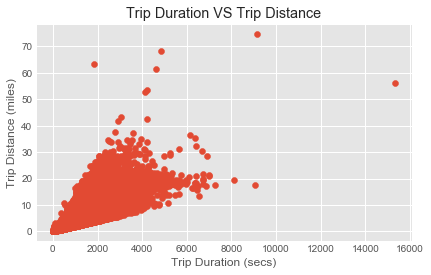

In [170]:
#EDA
plt.scatter(df['duration'], df['trip_distance'])
plt.title('Trip Duration VS Trip Distance')
plt.xlabel('Trip Duration (secs)')
plt.ylabel('Trip Distance (miles)')
plt.show()

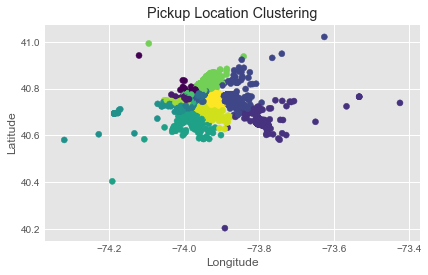

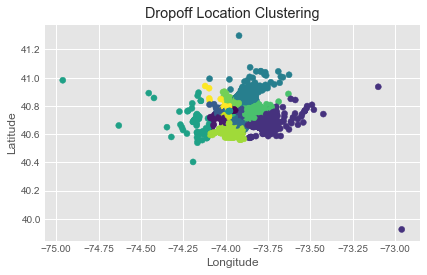

In [171]:
#clustering pickup and dropoff locations
n = len(df)
kmeans_pickup = KMeans(n_clusters = 15, random_state = 2).fit(df[['pickup_latitude', 'pickup_longitude']])
df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude','pickup_longitude']])
plt.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_pickup[:n])
plt.title('Pickup Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

kmeans_dropoff = KMeans(n_clusters = 15, random_state = 2).fit(df[['dropoff_latitude', 'dropoff_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude','dropoff_longitude']])
plt.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_dropoff[:n])
plt.title('Dropoff Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [172]:
#creating dummy variables/one hot encoding, adding features
df = pd.concat([df, pd.get_dummies(df['pickup_hrs'], prefix = 'hrs')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['day_week'], prefix = 'day')], axis = 1)
df['pickup_dropoff_cluster'] = df['kmeans_pickup'].map(str) + 'to' +  df['kmeans_dropoff'].map(str)
df = pd.concat([df, pd.get_dummies(df['pickup_dropoff_cluster'], prefix = 'route')], axis = 1)

In [173]:
##cleaninig df for training containig only features
df.drop(df.columns[[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 47]], axis = 1, inplace = True)

In [174]:
#writing cleaned data to file for post prediction analysis and tuning hyperparameyres for Randomforest
df.to_csv('post_analysis_data.csv')

In [175]:
## Training the model

In [176]:
from sklearn.model_selection import train_test_split
X = np.array(df.drop(['duration'], 1))
y = np.array(df['duration'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
clf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [177]:
##Making Predictions

In [178]:
accuracy = clf.score(X_test, y_test)


In [179]:
accuracy

0.8160885272743699

In [180]:
#Tuning/Analysing the hyperparameters to improve confidence

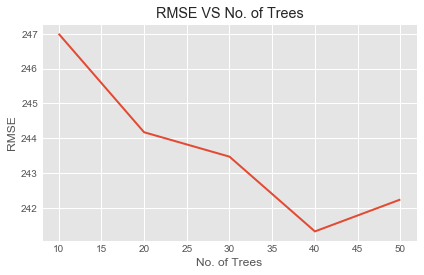

In [181]:
#Analysing the required number of trees for RandomForest
a = np.array([[10, 247]])
for i in range(20, 60, 10):
    clf = RandomForestRegressor(n_estimators = i)
    clf.fit(X_train, y_train)
    y_actual = y_test
    y_pred = clf.predict(X_test)
    rms = sqrt(mean_squared_error(y_actual, y_pred))
    a = np.append(a, [[i, rms]], axis = 0)
    
plt.plot(a[:, 0], a[:, 1], linewidth = 2.0)
plt.title('RMSE VS No. of Trees')
plt.xlabel('No. of Trees')
plt.ylabel('RMSE')
plt.show()